# Finding h- and W-Theta at h-

In [1]:
# import the basics
import pysr
from pysr import PySRRegressor

import xarray as xr
import netCDF4 as nc
import h5netcdf
import pandas as pd
import re

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from glob import glob

# sara also has
from netCDF4 import Dataset
import os

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
folder_path = '/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/'

nc_test1 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_I.nc'), mode='r')
z_256 = nc_test1.variables['z'][:]
zh_257 = nc_test1.variables['zh'][:]
t_120 = nc_test1.variables['time'][:]

nc_test2 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_IV.nc'), mode='r')
z_384 = nc_test2.variables['z'][:]
zh_385 = nc_test2.variables['zh'][:]
t_90 = nc_test2.variables['time'][:]
print(len(z_256), len(zh_257), len(t_120), len(z_384), len(zh_385), len(t_90))

256 257 120 384 385 90


In [3]:
def read_data_og(filepath):
    """
    Reads in each dataset and returns an xarray dataset
    """

    ds_thm = xr.open_dataset(f"{filepath}",
                             decode_times=False, group="thermo")
    ds_bud = xr.open_dataset(f"{filepath}",
                            decode_times=False, group="budget")
    ds_def = xr.open_dataset(f"{filepath}", 
                             decode_times=False, group="default")
    ds = xr.merge([ds_thm, ds_bud, ds_def], join="inner")

    if len(ds.time) == 90:
        ds = ds.assign_coords({"time": t_90}).swap_dims({"time":"time"})
    elif len(ds.time) == 120:
        ds = ds.assign_coords({"time": t_120}).swap_dims({"time":"time"})

    if len(ds.z) == 256:
        ds = ds.assign_coords({"z": z_256}).swap_dims({"z":"z"})
    elif len(ds.z) == 384:
        ds = ds.assign_coords({"z": z_384}).swap_dims({"z":"z"})

    if len(ds.zh) == 257:
        ds = ds.assign_coords({"zh": zh_257}).swap_dims({"zh":"zh"})
    elif len(ds.zh) == 385:
        ds = ds.assign_coords({"zh": zh_385}).swap_dims({"zh":"zh"})

    return ds

In [4]:
# updated read_data to take in a filename instead of a folder_path
folder_path = '/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/'

def read_data(filename):
    """
    Reads in each dataset and returns an xarray dataset
    """
    filepath = os.path.join(folder_path, filename)  # Assuming folder_path is accessible globally

    ds_thm = xr.open_dataset(f"{filepath}",
                             decode_times=False, group="thermo")
    ds_bud = xr.open_dataset(f"{filepath}",
                             decode_times=False, group="budget")
    ds_def = xr.open_dataset(f"{filepath}",
                             decode_times=False, group="default")
    ds = xr.merge([ds_thm, ds_bud, ds_def], join="inner")

    if len(ds.time) == 90:
        ds = ds.assign_coords({"time": t_90}).swap_dims({"time":"time"})
    elif len(ds.time) == 120:
        ds = ds.assign_coords({"time": t_120}).swap_dims({"time":"time"})

    if len(ds.z) == 256:
        ds = ds.assign_coords({"z": z_256}).swap_dims({"z":"z"})
    elif len(ds.z) == 384:
        ds = ds.assign_coords({"z": z_384}).swap_dims({"z":"z"})

    if len(ds.zh) == 257:
        ds = ds.assign_coords({"zh": zh_257}).swap_dims({"zh":"zh"})
    elif len(ds.zh) == 385:
        ds = ds.assign_coords({"zh": zh_385}).swap_dims({"zh":"zh"})

    return ds

* Four inversion cases, i being the strong inversion and iv the weakest (temperature inversion that occurs at the top of the ABL)
* Surface Heating (Q): Influences the heat profile.
* Wind (Ug): Imposed wind; affects the movement and distribution of air properties.
* Inversion (dtheta/dz): Impacts the stratification and stability, influencing PBL growth.

In [5]:
# renaming files according to their inversion strength, wind, and surface heating
folder_path = '/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/'
files = glob(f"{folder_path}/*")

for file in files:
    print(file)

/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q006_I.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q006_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q003_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q010_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q024_I.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q003_III.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q001_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q01_III.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q003_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q010_I.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug1Q01_II.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q003_II.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q000_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q010_IV.nc
/Users/gretavanzetten/Desktop/LE

In [6]:
# put all file names into one list for accessability later
file_names = [
    "Ug16Q006_I.nc", 
    "Ug8Q006_IV.nc", 
    "Ug8Q003_IV.nc",
    "Ug16Q010_IV.nc",
    "Ug2Q024_I.nc",
    "Ug8Q003_III.nc",
    "Ug16Q001_IV.nc",
    "Ug2Q01_III.nc",
    "Ug16Q003_IV.nc",
    "Ug2Q010_I.nc",
    "Ug1Q01_II.nc",
    "Ug8Q003_II.nc",
    #"Ug16Q000_IV.nc",
    "Ug2Q010_IV.nc",
    "Ug16Q006_IV.nc"
]

In [7]:
# put all the files into one dataset
datasets = [
    read_data(files[0]),
    read_data(files[1]),
    read_data(files[2]),
    read_data(files[3]),
    read_data(files[4]),
    read_data(files[5]),
    read_data(files[6]),
    read_data(files[7]),
    read_data(files[8]),
    read_data(files[9]),
    read_data(files[10]),
    read_data(files[11]),
    # no Ug16Q000_IV.nc
    read_data(files[13]),
    read_data(files[14])
]

In [8]:
# print short and long names of variables within each group 
### default - velocity terms
### thermo - buoyancy or theta
### budget - TKE or heat budget terms

df = nc.Dataset(files[10], mode='r')
for group_name, group in df.groups.items():
    print(f"Group: {group_name}")
    for var_name, var in group.variables.items():
        long_name = var.getncattr('long_name') if 'long_name' in var.ncattrs() else 'No long name'
        dimensions = var.dimensions if hasattr(var, 'dimensions') else 'No dimensions attribute'
        print(f"Variable: {var_name}, Long Name: {long_name}, Dimensions: {dimensions}")
    print("\n")
df.close()

Group: default
Variable: iter, Long Name: Iteration number, Dimensions: ('time',)
Variable: area, Long Name: Fractional area contained in mask, Dimensions: ('time', 'z')
Variable: areah, Long Name: Fractional area contained in mask, Dimensions: ('time', 'zh')
Variable: eft, Long Name: eft, Dimensions: ('time', 'z')
Variable: eft_3, Long Name: Moment 3 of the eft, Dimensions: ('time', 'z')
Variable: eft_4, Long Name: Moment 4 of the eft, Dimensions: ('time', 'z')
Variable: eft_diff, Long Name: Diffusive flux of the eft, Dimensions: ('time', 'zh')
Variable: eft_w, Long Name: Turbulent flux of the eft, Dimensions: ('time', 'zh')
Variable: eft_grad, Long Name: Gradient of the eft, Dimensions: ('time', 'zh')
Variable: eft_2, Long Name: Moment 2 of the eft, Dimensions: ('time', 'z')
Variable: eft_path, Long Name: eft path, Dimensions: ('time',)
Variable: eft_flux, Long Name: Total flux of the eft, Dimensions: ('time', 'zh')
Variable: sft, Long Name: sft, Dimensions: ('time', 'z')
Variable: s

### Helpful Variable Names
* pbl_height = 'zi' 
* mean potential temperature = 'th'
* heat_flux = 'th_flux' 
* time = 'time'

Want to look at $\theta$ flux and find the minimum $\rightarrow$ the minimum is h-

In [9]:
def time_average(data_array, timeavg):
    """
    Parameters:
    - data_array (xarray.DataArray),input data array with 'time' dimension
    - timeavg (int), number of time steps to average over

    Returns:
    - xarray.DataArray, time-averaged data array.
    """
    # make sure timeavg is positive int + smaller than the length of data
    if timeavg <= 0 or timeavg > data_array.sizes["time"]:
        raise ValueError("timeavg must be a positive integer less than or equal to the number of time steps in data.")

    # resample data array by averaging over specified intervals
    averaged_data_array = data_array.coarsen(time=timeavg, boundary="trim").mean()

    return averaged_data_array

In [10]:
def time_avg_gen(data, timeavg):
    """
    Averages an array over specified number of time steps. Works for both 1D and higher-dimensional arrays.

    Parameters:
    - data (numpy.ndarray): The input data array. Expected shapes are either (ntime,) or (ntime, nz).
    - timeavg (int): The number of time steps over which to average.

    Returns:
    - numpy.ndarray: The averaged data array.
    """
    ntime = data.shape[0]
    nchunks = ntime // timeavg
    truncated_data = data[:nchunks * timeavg]

    if data.ndim == 1:
        # for 1D arrays, reshape to (nchunks, timeavg)
        reshaped_data = truncated_data.reshape(nchunks, timeavg)
    else:
        # for 2D arrays, old method with reshaping
        nz = data.shape[1]
        reshaped_data = truncated_data.reshape(nchunks, timeavg, nz)

    # compute the mean along the new time axis 
    averaged_data = reshaped_data.mean(axis=1)

    return averaged_data

In [11]:
def make_gvars(path, items, time_avg):
    """
    Extracts the variables of interest from the LES simulations and averages them over specified number of time steps.
    Parameters:
    - path (str): The path to the LES simulation data.
    - items (list): A list of file names containing the LES simulation data. Ex: ['Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_I.nc']
    - time_avg (int): The number of time steps over which to average.
    Returns:
    - time averaged hmins
    - time averaged wtheta_hmins
    - time averaged heights
    - time averaged dtheta_ml_dt
    - time averaged wtheta_sfc
    - time averaged w'b'_sfc
    """
    # Initialize empty lists to accumulate results
    hmin = []
    wtheta_hmin = []
    h = []
    dtheta_ml_dt = []
    wtheta_sfc = []
    wb_sfc = []
    
    for item in items:
        
        hmin_temp = []
        wtheta_hmin_temp = []

        ds_stat = nc.Dataset(os.path.join(path, item), mode='r')
        wtheta = ds_stat.groups['thermo']['th_flux'][:]
        zh = ds_stat.variables['zh'][:]
        height = time_avg_gen(ds_stat.groups['thermo']['zi'][:], time_avg)
        theta_ml_temp= (ds_stat.groups['thermo']['th'][:])[:, 75]
        time = ds_stat.variables['time'][:] 
        wtheta_sfc_temp = time_avg_gen(wtheta[:, 0], time_avg)
        wb = ds_stat.groups['thermo']['b_flux'][:] #figure out how to get bflux at surface
        wb_sfc_temp = time_avg_gen(wb[:, 0], time_avg)

        #if needed done in minutes (not sec), comment out " time = ", and dtheta, and uncomment line below
        # dtheta_ml_temp = time_avg_gen(np.gradient(theta_ml_temp), time_avg)

        dtheta_ml_temp = time_avg_gen(np.gradient(theta_ml_temp, time), time_avg)
        
        for t in range(wtheta.shape[0]):
            wtheta_at_t = wtheta[t]
            min_wtheta = np.min(wtheta_at_t)
            min_height = zh[np.argmin(wtheta_at_t)]
            hmin_temp.append(min_height)
            wtheta_hmin_temp.append(min_wtheta)
        
        # ---- added by chat to make sure passing a 'xarray.DataArray' into my 'time_average' function
        time_coords = np.arange(len(hmin_temp)) # first add time coordinates to 'time_average' 

        #convert numpy arrays to xarray.DataArray
        hmin_data_array = xr.DataArray(hmin_temp, dims=["time"], coords={"time": time_coords})
        wtheta_hmin_data_array = xr.DataArray(wtheta_hmin_temp, dims=["time"], coords={"time": time_coords})

        # Use the time_average function with xarray.DataArray
        hmin_temp_timeavg = time_average(hmin_data_array, time_avg)
        wtheta_hmin_temp_timeavg = time_average(wtheta_hmin_data_array, time_avg)

        # Append the results to the respective lists
        hmin.append(hmin_temp_timeavg)
        wtheta_hmin.append(wtheta_hmin_temp_timeavg)
        h.append(height)
        dtheta_ml_dt.append(dtheta_ml_temp)
        wtheta_sfc.append(wtheta_sfc_temp)
        wb_sfc.append(wb_sfc_temp)
    
    # Concatenate the results along the time axis
    hmin = np.concatenate(hmin, axis=0)
    wtheta_hmin = np.concatenate(wtheta_hmin, axis=0)
    h = np.concatenate(h, axis=0)
    dtheta_ml_dt = np.concatenate(dtheta_ml_dt, axis=0)
    wtheta_sfc = np.concatenate(wtheta_sfc, axis=0)
    wb_sfc = np.concatenate(wb_sfc, axis=0)
    
    return hmin, wtheta_hmin, h, dtheta_ml_dt, wtheta_sfc, wb_sfc

In [12]:
hmin, wtheta_hmin, h, dtheta_ml_dt, wtheta_sfc, wb_sfc = make_gvars(folder_path, file_names, 15)

In [13]:
print("w'b'_sfc LENGTH: ", len(wb_sfc))
print(wb_sfc)


w'b'_sfc LENGTH:  106
[0.001962 0.001962 0.001962 0.001962 0.001962 0.001962 0.001962 0.001962
 0.001962 0.001962 0.001962 0.001962 0.001962 0.001962 0.001962 0.001962
 0.000981 0.000981 0.000981 0.000981 0.000981 0.000981 0.000981 0.000981
 0.00327  0.00327  0.00327  0.00327  0.00327  0.00327  0.007848 0.007848
 0.007848 0.007848 0.007848 0.007848 0.007848 0.007848 0.000981 0.000981
 0.000981 0.000981 0.000981 0.000981 0.000981 0.000981 0.000327 0.000327
 0.000327 0.000327 0.000327 0.000327 0.000327 0.000327 0.00327  0.00327
 0.00327  0.00327  0.00327  0.00327  0.00327  0.00327  0.000981 0.000981
 0.000981 0.000981 0.000981 0.000981 0.000981 0.000981 0.00327  0.00327
 0.00327  0.00327  0.00327  0.00327  0.00327  0.00327  0.00327  0.00327
 0.00327  0.00327  0.00327  0.00327  0.00327  0.00327  0.000981 0.000981
 0.000981 0.000981 0.000981 0.000981 0.000981 0.000981 0.00327  0.00327
 0.00327  0.00327  0.00327  0.00327  0.001962 0.001962 0.001962 0.001962
 0.001962 0.001962]


In [14]:
wtheta_min_option2 = wtheta_hmin - (hmin * dtheta_ml_dt)
wtheta_min_option2

masked_array(data=[-0.11080831, -0.1091009 , -0.10527062, -0.1015108 ,
                   -0.10118549, -0.10709042, -0.1145908 , -0.10864435,
                   -0.08004332, -0.08602585, -0.08483699, -0.08356642,
                   -0.08775648, -0.08683166, -0.08943583, -0.08267601,
                   -0.04580541, -0.04218394, -0.04676521, -0.04411823,
                   -0.04680923, -0.04210697, -0.04450182, -0.04198386,
                   -0.1565537 , -0.14943063, -0.1444338 , -0.16114153,
                   -0.15455831, -0.16508746, -0.34321443, -0.34649809,
                   -0.34929184, -0.34736975, -0.3498861 , -0.34347865,
                   -0.35318255, -0.34001471, -0.04517206, -0.041294  ,
                   -0.04516118, -0.0438962 , -0.04756424, -0.04642757,
                   -0.04756369, -0.04422102, -0.02750254, -0.03204455,
                   -0.03008378, -0.02680331, -0.02749969, -0.02559312,
                   -0.0241817 , -0.02387807, -0.14122475, -0.14012992,
      

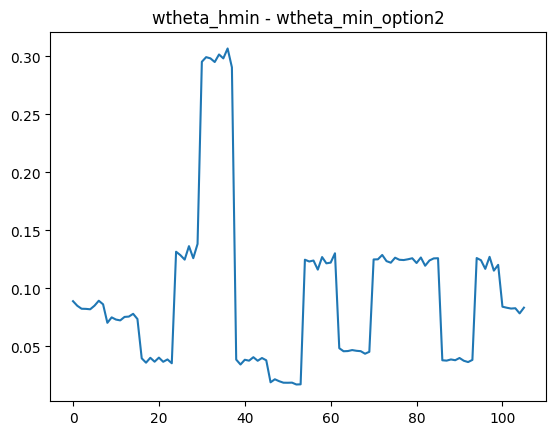

In [15]:
# difference between wtheta_hmin (caclulated from wtheta at h) and wtheta_min_option2 (residual calculation)
# for all simulations

plt.plot(wtheta_hmin - wtheta_min_option2)
plt.title("wtheta_hmin - wtheta_min_option2")
plt.show()

In [16]:
# pulling variables from individual simulations to compare their w_theta calculation differences

# variables for "Ug8Q006_IV.nc"
hmin_r1, wtheta_hmin_r1, h_r1, dtheta_ml_dt_r1, wtheta_sfc_r1, wb_sfc_r1 = make_gvars(folder_path, ['Ug8Q006_IV.nc'], 15)

# variables for "Ug16Q006_I.nc"
hmin_r2, wtheta_hmin_r2, h_r2, dtheta_ml_dt_r2, wtheta_sfc_r2, wb_sfc_r2 = make_gvars(folder_path, ['Ug16Q006_I.nc'], 15)

# variables for "Ug2Q01_III.nc"
hmin_r3, wtheta_hmin_r3, h_r3, dtheta_ml_dt_r3, wtheta_sfc_r3, wb_sfc_r3 = make_gvars(folder_path, ['Ug2Q01_III.nc'], 15)

# wtheta_min
wtheta_min_option2_r1 = wtheta_hmin_r1 - (hmin_r1 * dtheta_ml_dt_r1)
wtheta_min_option2_r2 = wtheta_hmin_r2 - (hmin_r2 * dtheta_ml_dt_r2)
wtheta_min_option2_r3 = wtheta_hmin_r3 - (hmin_r3 * dtheta_ml_dt_r3)

<function matplotlib.pyplot.show(close=None, block=None)>

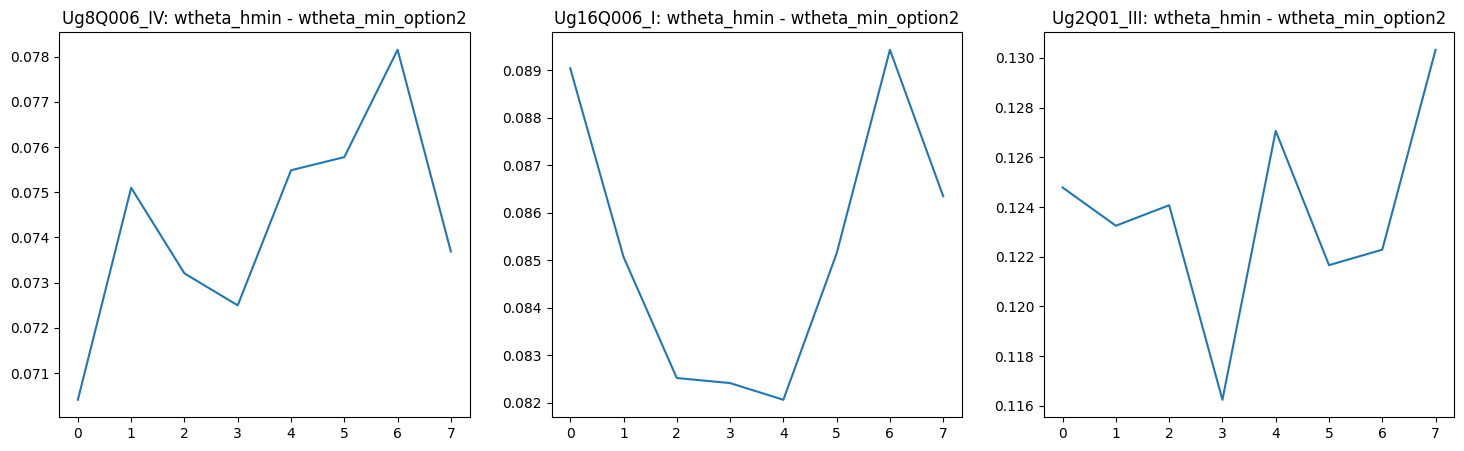

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

#
axs[0].plot(wtheta_hmin_r1 - wtheta_min_option2_r1)
axs[0].set_title('Ug8Q006_IV: wtheta_hmin - wtheta_min_option2')

# Second plot
axs[1].plot(wtheta_hmin_r2 - wtheta_min_option2_r2)
axs[1].set_title('Ug16Q006_I: wtheta_hmin - wtheta_min_option2')

# Third plot
axs[2].plot(wtheta_hmin_r3 - wtheta_min_option2_r3)
axs[2].set_title('Ug2Q01_III: wtheta_hmin - wtheta_min_option2')


plt.show

### Estimating Entrainment Flux

From the textbook:
$$ h^-\frac{d\theta_{ml}}{dt} = -\overline{w\theta_{h^-}} + \overline{w\theta_{sfc}} $$

Laura's discovered equation:
$$ w_e = 9.961432 * \frac{\overline{w'b'_{sfc}}}{\Delta\theta_\rho} + 0.0009702546*Ug $$

Previous studies assume that the minimum flux equals the entrainment flux, $$\overline{w\theta_{h^-}} = w_e\Delta\theta_\rho $$ Where they say, $w_e\Delta\theta = A\overline{w'b'_{sfc}} $ and $w_e = \frac{A\overline{w'b'_{sfc}}}{\Delta\theta_\rho} $

### Next Steps:
Now I want to compare the $\overline{w\theta_{h^-}}$ from the data to the $w_e$ equation Laura found, multiplied by $\Delta\theta_\rho$. In order to do this I need to:
- Calculate $\Delta\theta_\rho$ (by modifying Laura's find_jump second derivative method)
- Pull the Ug value from the file names to also plug into Laura's eq
- Pull/calculate $\overline{w\theta_{sfc}}$ for each file

In [18]:
# Laura's second derivative method to find delta-theta_p
def find_jump(ds, filter_num=.001):
    """
    Inputs: 
    - ds: an xarray Dataset containing 'th' (potential temp) with dimensions 'time' and 'z' (height)
    Returns:
    - ds: a modified xarray Dataset with new variable del_th_sd & only the time coordinate
    """
    #making an array to store all the values of th_jump
    th_jump = np.array([])

    #prepping ds
    ds_jump = ds.copy()
    ds_jump = ds_jump[["th"]]

    #looping through every time and calculating th_jump
    for i in range(len(ds_jump.time)):

        #calculating the second derivate using np.diff
        #(central diff)
        diff_df = np.diff(ds_jump.isel(time=i).th, n=2)

        #putting the array into a dataframe to preserve the index
        #(height var)
        diff_df = pd.DataFrame(diff_df)
        diff_df = diff_df.reset_index()
        diff_df = diff_df.rename(columns={"index": "z", 0:"sec_der"})

        #chopping off the beginning and end of the df
        diff_df = diff_df.iloc[50:350]

        #filtering the df to only select for heights
        #with big enough second derivatives
        diff_df = diff_df[np.abs(diff_df["sec_der"]) >= filter_num]

        if len(diff_df) == 0:
            return "Try different filter num, everything filtered out"
        

        #getting the heights
        if (diff_df.z.iloc[1] - diff_df.z.iloc[0]) <= 1:
            min_z = diff_df.z.iloc[0]
        #making sure to cut off tails of sparse values
        else:
            j = 1
            while (diff_df.z.iloc[j+1] - diff_df.z.iloc[j]) >= 2:
                min_z = diff_df.z.iloc[j]
                j+=1

        
        if (diff_df.z.iloc[-1] - diff_df.z.iloc[-2]) <= 1:
            max_z = diff_df.z.iloc[-1]
        #making sure to cut off tails of sparse values
        else:
            j=-2
            while (diff_df.z.iloc[j] - diff_df.z.iloc[j-1]) >=2:
                max_z = diff_df.z.iloc[j]
                j-=1
        
        #calc th_jump
        jump = (ds_jump.isel(time=i, z=max_z).th.values - ds_jump.isel(time=i, z=min_z).th.values)
        if jump < 0:
            return f"Error in calculation: th_jump at time={i} is negative"

        #adding values to array
        if len(th_jump) == 0:
            th_jump = np.array([jump])
        else:
            th_jump = np.concatenate((th_jump, np.array([jump])))

    if len(th_jump) != len(ds_jump.time):
        return "Error in code"
    
    #adding array of th_jumps to the original ds, index is time
    ds = ds.assign(del_th_sd=(['time'],th_jump))

    return ds

In [67]:
# laura's original UNMODIFIED find_jump function -- to use later for eq discovery
def laura_find_jump(ds, filter_num=.001):
    """
    Returns a dataset with the new variable
    del_th_sd, del_sft, del_eft with only the time coordinate
    """
    #making an array to store all the values of th_jump
    th_jump = np.array([])
    sft_jump = np.array([])
    eft_jump = np.array([])

    #prepping ds
    ds_jump = ds.copy()
    ds_jump = ds_jump[["th", "eft", "sft"]]

    #looping through every time and calculating th_jump
    for i in range(len(ds_jump.time)):

        #calculating the second derivate using np.diff
        #(central diff)
        diff_df = np.diff(ds_jump.isel(time=i).th, n=2)

        #putting the array into a dataframe to preserve the index
        #(height var)
        diff_df = pd.DataFrame(diff_df)
        diff_df = diff_df.reset_index()
        diff_df = diff_df.rename(columns={"index": "z", 0:"sec_der"})

        #chopping off the beginning and end of the df
        diff_df = diff_df.iloc[50:350]

        #filtering the df to only select for heights
        #with big enough second derivatives
        diff_df = diff_df[np.abs(diff_df["sec_der"]) >= filter_num]

        if len(diff_df) == 0:
            return "Try different filter num, everything filtered out"
        
        #getting the heights
        if (diff_df.z.iloc[1] - diff_df.z.iloc[0]) <= 1:
            min_z = diff_df.z.iloc[0]
        #making sure to cut off tails of sparse values
        else:
            j = 1
            while (diff_df.z.iloc[j+1] - diff_df.z.iloc[j]) >= 2:
                min_z = diff_df.z.iloc[j]
                j+=1

        
        if (diff_df.z.iloc[-1] - diff_df.z.iloc[-2]) <= 1:
            max_z = diff_df.z.iloc[-1]
        #making sure to cut off tails of sparse values
        else:
            j=-2
            while (diff_df.z.iloc[j] - diff_df.z.iloc[j-1]) >=2:
                max_z = diff_df.z.iloc[j]
                j-=1
        
        #calc th_jump
        jump_th = (ds_jump.isel(time=i, z=max_z).th.values - ds_jump.isel(time=i, z=min_z).th.values)
        jump_sft = (ds_jump.isel(time=i, z=max_z).sft.values - ds_jump.isel(time=i, z=min_z).sft.values)
        jump_eft = (ds_jump.isel(time=i, z=max_z).eft.values - ds_jump.isel(time=i, z=min_z).eft.values)

        #adding values to array
        if len(th_jump) == 0:
            th_jump = np.array([jump_th])
            sft_jump = np.array([jump_sft])
            eft_jump = np.array([jump_eft])
        else:
            th_jump = np.concatenate((th_jump, np.array([jump_th])))
            sft_jump = np.concatenate((sft_jump, np.array([jump_sft])))
            eft_jump = np.concatenate((eft_jump, np.array([jump_eft])))

    if len(th_jump) != len(ds_jump.time):
        return "Error in code"
    
    #adding array of th_jumps to the original ds, index is time
    ds = ds.assign(del_th_sd=(['time'],th_jump))
    ds = ds.assign(del_sft_sd=(["time"], sft_jump))
    ds = ds.assign(del_eft_sd=(["time"], eft_jump))

    return ds

Utilizing Laura's find_jump funciton above, I now compare $\overline{w\theta_{h^-}} $ with the right hand side of the equation, $w_e\Delta\theta_{\rho} $ 

The cell below is a test I did for one file -- to go through all the files continue down to "flux_compare()"

In [19]:
# comparing wtheta at h- with w_e * deltheta_p for "Ug16Q003_IV.nc"

# extracting wtheta_hmin_f1 (f1 represents file 1:Ug16Q006_I)
hmin_f1, wtheta_hmin_f1, h_f1, dtheta_ml_dt_f1, wtheta_sfc_f1, wb_sfc_f1 = make_gvars(folder_path, ["Ug16Q003_IV.nc"], 15)

# getting deltheta_p using laura's second-derivative method
del_th_f1 = find_jump(read_data(files[8]), .00075)
timeavg_del_th_f1 = time_average(del_th_f1[["del_th_sd"]], 15).to_array()
Ug = 16 #hard coding in Ug value until I find a better way to extract

# converting to numpy array
#timeavg_del_th_np = timeavg_del_th_f1.to_array()

#calculating w_e
w_e_np = -(9.961432 * (wb_sfc_f1 / timeavg_del_th_f1) + (0.0009702546 * Ug))

# right hand side of equation
# rhs_f1 = w_e_np * timeavg_del_th_f1['del_th_sd'].values
rhs_f1 = w_e_np * timeavg_del_th_f1

# comparing lhs and rhs
dif_f1 = wtheta_hmin_f1 - rhs_f1

print("For Ug16Q003_IV")
print("wtheta_hmin: ", wtheta_hmin_f1)
print("wtheta_sfc: ", wtheta_sfc_f1)
print("w_e: ", w_e_np)
print("rhs: ", rhs_f1)
print("difference btwn sides: ", dif_f1)

For Ug16Q003_IV
wtheta_hmin:  [-0.01359931 -0.01698981 -0.01563491 -0.01098747 -0.01203248 -0.01238024
 -0.00980826 -0.00980907]
wtheta_sfc:  [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
w_e:  [[-0.0235524856324561 -0.023019863992749936 -0.022589778496342236
  -0.02214592554644108 -0.0220516704645552 -0.021806058673690835
  -0.02175649328755326 -0.02168316269545401]]
rhs:  [[-0.028668031726712687 -0.030010698357328523 -0.03124260655087821
  -0.03268173853199731 -0.033012540784899805 -0.03392118833834321
  -0.03411324146328124 -0.03440304820856049]]
difference btwn sides:  [[0.01506872570319074 0.013020893077499339 0.015607697858280471
  0.021694268023653533 0.02098005866514099 0.02154094732119971
  0.02430498502626325 0.0245939831151159]]


<function matplotlib.pyplot.show(close=None, block=None)>

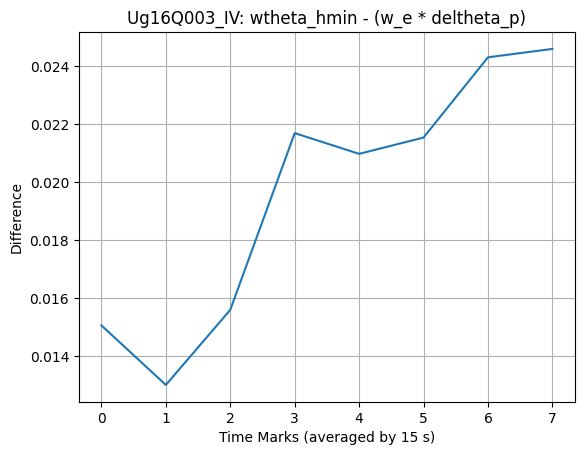

In [20]:
# get values from dif_f1 and flatten
dif_f1_flat = np.array(dif_f1).flatten()

plt.plot(dif_f1_flat)
plt.title('Ug16Q003_IV: wtheta_hmin - (w_e * deltheta_p)')
plt.xlabel('Time Marks (averaged by 15 s)')
plt.ylabel('Difference')
plt.grid(True)
plt.show

In [21]:
# dictionary of filter numbers for respective simulation files -- utilized in find_jump
def get_filter_num(item):
    filter_numbers = {
        "Ug16Q006_I.nc": 0.0002,
        "Ug16Q010_IV.nc": 0.0002,
        "Ug1Q01_II.nc": 0.0005,
        "Ug2Q010_I.nc": 0.00025,
        "Ug2Q024_I.nc": 0.002,
        "Ug16Q003_IV.nc": 0.0075,
        "Ug16Q003_IV.nc": 0.00075
    }
    return filter_numbers.get(item, .001)

In [60]:
# get Ug and Q values from file names for later on equation discovery -- OLD: actually don't end up using
def ug_q_values(filenames):
    ugs = []
    qs = []
    
    for item in filenames:
        # Extract Ug value
        ug_match = re.search(r'Ug(\d+)', item)
        if ug_match:
            ugs.append(int(ug_match.group(1)))
        else:
            raise ValueError(f"Cannot find 'Ug' in file name: {item}")
        
        # Extract Q value
        q_match = re.search(r'Q(\d+)', item)
        if q_match:
            qs.append(int(q_match.group(1)))
        else:
            raise ValueError(f"Cannot find 'Q' in file name: {item}")

    return ugs, qs

In [62]:
ug1, q1 = ug_q_values(file_names)

print(ug1)
print(q1)

[16, 8, 8, 16, 2, 8, 16, 2, 16, 2, 1, 8, 2, 16]
[6, 6, 3, 10, 24, 3, 1, 1, 3, 10, 1, 3, 10, 6]


In [22]:
def flux_variables(path, items, timeavg):
    """
    Extracts  variables of interest from  LES simulations and averages them over specified number of time steps.
    
    Parameters:
    - path (str): The path to the LES simulation data.
    - items (list): A list of file names containing the LES simulation data. Ex: ['Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_I.nc']
    - time_avg (int): The number of time steps over which to average.

    Returns:
    - wtheta_hmin2 (numpy array): time averaged wtheta_hmin
    - wb_sfc2 (numpy array): time averaged w'b'_sfc
    """
    # initialize empty list to accumulate results
    wtheta_hmin2 = []
    wb_sfc2 = []

    for item in items:
        hmin_temp2 = []
        wtheta_hmin_temp2 = []

        d_stat = nc.Dataset(os.path.join(path, item), mode='r')
        wtheta2 = d_stat.groups['thermo']['th_flux'][:]
        zh2 = d_stat.variables['zh'][:]
        wb2 = d_stat.groups['thermo']['b_flux'][:]
        wb_sfc_temp2 = time_avg_gen(wb2[:, 0], timeavg)

        for t in range(wtheta2.shape[0]):
            wtheta_at_t2 = wtheta2[t]
            min_wtheta2 = np.min(wtheta_at_t2)
            min_height2 = zh2[np.argmin(wtheta_at_t2)]
            hmin_temp2.append(min_height2)
            wtheta_hmin_temp2.append(min_wtheta2)
    
        # convert wtheta_hmin to numpy array before time averaging
        wtheta_hmin_temp2_timeavg = time_avg_gen(np.array(wtheta_hmin_temp2), timeavg)

        # append results to respective lists 
        wb_sfc2.append(np.array(wb_sfc_temp2))
        wtheta_hmin2.append(wtheta_hmin_temp2_timeavg)
    
    # concatenate results along time axis
    wtheta_hmin2 = np.concatenate(wtheta_hmin2, axis=0).flatten()
    wb_sfc2 = np.concatenate(wb_sfc2, axis=0).flatten()

    return wtheta_hmin2, wb_sfc2

In [76]:
# comparing the minimum flux to the entrainment flux throughout all simulations
def flux_compare(path, items, timeavg):
    """
    Parameters:
    - path (str): The path to the LES simulation data.
    - items (list): A list of file names containing the LES simulation data. Ex: ['Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_I.nc']
   
    Returns:
    - flux_diff (numpy array): Difference between wtheta_hmin and w_e * deltheta_p
    - w_e (numpy array): Laura's discovered w_e equation: -(9.961432 * bflux/del_th + 0.0009702546*Ug)
    - rhs (numpy array): Right hand side of the equation: w_e * deltheta_p
    - wtheta_hmin2 (numpy array): wtheta_hmin
    - wb_sfc2 (numpy array): w'b'_sfc
    = dtheta_p (numpy array): deltheta_rho
    """

    # initialize empty list to accumulate results
    flux_diff = []
    w_e = []
    rhs = []
    wtheta_hmin2 = []
    wb_sfc2 = []
    dtheta_p = []

    for item in items: 

        # call flux_variables to get wtheta_hmin and w'b'_sfc
        wtheta_hmin3, wb_sfc3 = flux_variables(path, [item], timeavg)

        ds = read_data(item) #get data from file for find_jump
        filter_num = get_filter_num(item)

        # use laura's time_jump function to get deltheta_p (utilizes second derivative method)
        del_th_f2 = find_jump(ds, filter_num)
        timeavg_del_th = time_average(del_th_f2[["del_th_sd"]], timeavg).to_array()
        reshape_del_th = timeavg_del_th.values.reshape(-1)

        # get Ug value
        match = re.search(r'Ug(\d+)', item)
        if match:
            Ug_value = int(match.group(1))
        else:
            raise ValueError(f"Cannot find 'Ug' in file name: {item}")

        # calculate w_e
        w_e_np2 = -(10.750893 * (wb_sfc3 / reshape_del_th) + (0.0007610937 * Ug_value))

        # subtract entrainment flux from minimum flux to compare difference
        diff = wtheta_hmin3 + (w_e_np2 * reshape_del_th)
        w_exdeltheta_rho = w_e_np2 * reshape_del_th # w_e * deltheta_p as its own variable 

        # append results to list (flux_diff, w_e, rhs)
        flux_diff.append(diff) 
        w_e.append(w_e_np2)
        rhs.append(w_exdeltheta_rho)
        wtheta_hmin2.append(wtheta_hmin3.flatten())
        wb_sfc2.append(wb_sfc3.flatten())
        dtheta_p.append(reshape_del_th.flatten())

    # concatonate results along the time axis
    flux_diff = np.concatenate(flux_diff, axis=0).flatten()
    w_e = np.concatenate(w_e, axis=0).flatten()
    rhs = np.concatenate(rhs, axis=0).flatten()
    wtheta_hmin2 = np.concatenate(wtheta_hmin2, axis=0).flatten()
    wb_sfc2 = np.concatenate(wb_sfc2, axis=0).flatten()
    dtheta_p = np.concatenate(dtheta_p, axis=0).flatten()

    return flux_diff, w_e, rhs, wtheta_hmin2, wb_sfc2, dtheta_p

In [24]:
# file_names again but named fn so i can easily comment out/in certain files

fn = [
    "Ug16Q006_I.nc", 
    "Ug8Q006_IV.nc", 
    "Ug8Q003_IV.nc",
    "Ug16Q010_IV.nc",
    "Ug2Q024_I.nc",
    "Ug8Q003_III.nc",
    "Ug16Q001_IV.nc",
    "Ug2Q01_III.nc",
    "Ug16Q003_IV.nc",
    "Ug2Q010_I.nc",
    "Ug1Q01_II.nc",
    "Ug8Q003_II.nc",
    #"Ug16Q000_IV.nc",
    "Ug2Q010_IV.nc",
    "Ug16Q006_IV.nc"
]

In [77]:
# running flux_compare to graph difference comparison
flux_diff_r1, w_e_r1, rhs_r1, wtheta_hmin2, wb_sfc_x, dtheta_p1 = flux_compare(folder_path, fn, 15)

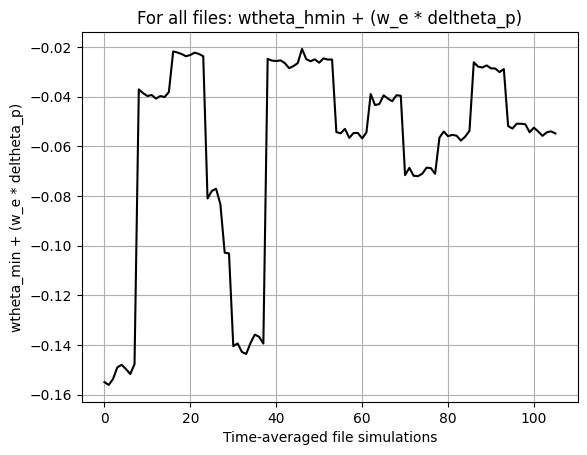

In [78]:
flux_diff_r1_flat = np.array(flux_diff_r1).flatten()

plt.plot(flux_diff_r1_flat, c="k")
#plt.plot(w_e_r1, c="r")
#plt.plot(w_exdeltheta_rho_r1, c="b")
plt.title("For all files: wtheta_hmin + (w_e * deltheta_p)")
plt.xlabel("Time-averaged file simulations")
plt.ylabel("wtheta_min + (w_e * deltheta_p)")
plt.grid(True)

In [28]:
# Comparing wtheta_hmin with w_e * deltheta_rho // wanted to make a scatter, but didn't really work

# flattening data for use
wtheta_flat = np.array(wtheta_hmin2).flatten()
rhs_flat = np.array(rhs_r1).flatten()

# plt.scatter(wtheta_flat, rhs_flat)
# plt.axline((0, 0), slope=1)
# plt.title('wtheta_hmin vs w_e * deltheta_rho')
# plt.xlabel('wtheta_hmin')
# plt.ylabel('w_e * deltheta_rho')
# plt.show

# Equation Discovery

After calculating the difference between $\overline{w\theta_{h^-}}$ and $w_e\Delta\theta_\rho $  for all simulations, I will run pysr to determine if there is a systematic overshoot.

In [68]:
### FROM LAURA for eq discov
def prep_ds(ds, ug, q, filter_num_sd=.001):
    """
    Makes an xarray dataset with all the necesscary variables for
    equation discovery"""

    ds_return = ds.copy()
    #selecting necessary vars
    ds_return = ds_return[["zi", "th", "th_flux", "b_flux",
                        "sft", "sft_flux", "eft", "eft_flux"]]

    #calc dh/dt
    dt = ds_return.time.isel(time=1).values - ds_return.time.isel(time=0).values
    bl_evo = np.gradient(ds_return.zi, int(dt))
    #adding dh/dt to ds
    ds_return = ds_return.assign(dh_dt=(['time'],bl_evo))

    #finding del_th
    ds_return = laura_find_jump(ds_return, filter_num_sd)

    #new method for del_eft
    ds_return["del_eft_new"] = 1 - ds_return.eft.isel(z=slice(50, 90)).mean("z")
    
    #making surface b_flux
    ds_return["b_flux_sfc"] = ds_return.b_flux.sel(zh=0)

    #making u_g var
    u_g = ug*np.ones((ds_return.time.shape))
    ds_return = ds_return.assign(u_g=(["time"], u_g))

    #making q var
    q = q*np.ones((ds_return.time.shape))
    ds_return = ds_return.assign(q=(["time"], q))

    #surface th flux
    ds_return["th_flux_sfc"] = ds_return.th_flux.isel(zh=0)

    #finding th_flux min
    ds_return["th_flux_min"] = ds_return.th_flux.min(dim="zh")

    #finding h_minus
    ds_return["h_minus"] = xr.where(ds_return["th_flux_min"],
                                     ds_return.isel(zh=ds_return.th_flux.argmin(dim="zh")).zh, 
                                     np.nan)
    
    #finding flux of sft at h_minus
    ds_return["sft_flux_min"] = ds_return.sft_flux.min(dim="zh")
    
    #finding flux of eft at h_minus
    ds_return["eft_flux_min"] = ds_return.eft_flux.min(dim="zh")

    #finding eft flux sfc
    ds_return["eft_flux_sfc"] = ds_return.eft_flux.isel(zh=0)

    #finding surface eft
    ds_return["eft_sfc"] = ds_return.eft.isel(z=0)

    #finding we from the discovered equation
    ds_return["we"] = 9.961432*ds_return["b_flux_sfc"]/ds_return["del_th_sd"] + 0.0009702546*ds_return["u_g"]

    #finding h deft/dt
    eft_evo = np.gradient(ds_return.isel(z=75).eft, int(dt))
    eft_evo_avg = np.gradient(ds_return.isel(z=slice(50, 90)).eft.mean("z"), int(dt))
    ds_return = ds_return.assign(deft_dt=(['time'],eft_evo))
    ds_return = ds_return.assign(deft_dt_avg=(['time'],eft_evo_avg))
    ds_return["h_deft_dt"] = ds_return.zi * ds_return.deft_dt
    ds_return["h_deft_dt_avg"] = ds_return.zi * ds_return.deft_dt_avg

    #calc we*del_eft from assumption
    ds_return["we_del_eft"] = ds_return["we"]*ds_return["del_eft_sd"]

    #resampling using coarsen across all variables
    ds_return = ds_return.coarsen(time=15).mean()
    
    return ds_return

In [69]:
## ALSO LAURA
iv16_1_ed = prep_ds(datasets[6], 16, 1, filter_num_sd=.001)
iv16_3_ed = prep_ds(datasets[8], 16, 3, filter_num_sd=.00075)
i16_6_ed = prep_ds(datasets[0], 16, 6, filter_num_sd=.0002)
iv16_6_ed = prep_ds(datasets[13], 16, 6)
iv16_10_ed = prep_ds(datasets[3], 16, 10)
ii1_1_ed = prep_ds(datasets[10], 10, 1)
i2_10_ed = prep_ds(datasets[9], 2, 10, filter_num_sd=.00025)
iv2_10_ed = prep_ds(datasets[12], 2, 10)
iii2_1_ed = prep_ds(datasets[7], 2, 1)
i2_24_ed = prep_ds(datasets[4], 2, 24, filter_num_sd=.002)
iii8_3_ed = prep_ds(datasets[5], 8, 3)
ii8_3_ed = prep_ds(datasets[11], 8, 3)
iv8_3_ed = prep_ds(datasets[2], 8, 3)
iv8_6_ed = prep_ds(datasets[1], 8, 6)

In [70]:
# queen laura's code yet again
def extract_var(var):
    """
    Returns a 1d array of the desired variable across all simulations
    """

    #making a list of all the simulations to loop through
    sim_list = [iv16_1_ed, iv16_3_ed, i16_6_ed,
            iv16_6_ed, iv16_10_ed, ii1_1_ed,
            i2_10_ed, iv2_10_ed, iii2_1_ed,
             i2_24_ed, iii8_3_ed, ii8_3_ed, 
            iv8_3_ed, iv8_6_ed]
    
    #making empty array to putt all the data in
    var_arr = np.array([])

    #making a 1d array of the var from the simulation
    for sim in sim_list:
        sim_var = sim[var].to_numpy()
        
        #adding to the var_arr
        if len(var_arr) == 0:
            var_arr = sim_var
        else:
            var_arr = np.concatenate((var_arr, sim_var))
    
    return var_arr

In [97]:
# extract variables
flux_diff_e1, w_e_e1, rhs_e1, wtheta_hmin_e1, wb_sfc_e1, dtheta_p_e1 = flux_compare(folder_path, fn, 15)
hmin_e1, wtheta_hmin_NO, h_e1, dtheta_ml_dt_e1, wtheta_sfc_e1, wb_sfc_NO = make_gvars(folder_path, file_names, 15)
q_values = extract_var("q")
ug_values = extract_var("u_g")

# variables that laura extracted
we = extract_var("we")
del_eft = extract_var("del_eft_new")
eft_sfc = extract_var("eft_sfc")
eft_flux_min = extract_var("eft_flux_min")
eft_flux_sfc = extract_var("eft_flux_sfc")
we_del_eft = -1* we * del_eft
th_flux_sfc = extract_var("th_flux_sfc")
del_th_sd = extract_var("del_th_sd")

### Making the Model

In [105]:
# stack inputs
X_multiplied = pd.DataFrame(np.column_stack([rhs_e1, wb_sfc_e1, wtheta_sfc_e1, ug_values, q_values]), 
                            columns=["rhs", "wb_sfc", "wtheta_sfc", "Ug_val", "Q_val"])
X_individual = pd.DataFrame(np.column_stack([w_e_e1, dtheta_p_e1, wb_sfc_e1, wtheta_sfc_e1, ug_values, q_values]), 
                            columns=["w_e", "dtheta_p", "wb_sfc", "wtheta_sfc", "Ug_val", "Q_val"])
X_lvars = pd.DataFrame(np.column_stack([w_e_e1, del_eft, eft_sfc,
                                  th_flux_sfc, dtheta_p_e1,
                                  eft_flux_sfc, q_values, ug_values]),
                columns=["we", "del_eft", "eft_sfc",
                         "th_flux_sfc", "detheta_p",
                         "eft_flux_sfc", "q", "u_g"])

# output
wtheta_hmin_y = pd.DataFrame(np.column_stack([wtheta_hmin_e1]), columns=["wtheta_hmin"])

In [80]:
X_individual

,w_e,dtheta_p,w'b'_sfc,wtheta_sfc,Ug,Q
0,-0.017647,9.207414,0.001962,0.06,16.0,1.0
1,-0.017669,9.112477,0.001962,0.06,16.0,1.0
2,-0.017691,9.019328,0.001962,0.06,16.0,1.0
3,-0.017711,8.935535,0.001962,0.06,16.0,1.0
4,-0.017732,8.851089,0.001962,0.06,16.0,1.0
...,...,...,...,...,...,...
101,-0.031487,1.224349,0.001962,0.06,8.0,6.0
102,-0.031315,1.237726,0.001962,0.06,8.0,6.0
103,-0.029310,1.417695,0.001962,0.06,8.0,6.0
104,-0.028928,1.458091,0.001962,0.06,8.0,6.0


Need to actually look more into PySR and learn how it works -- this is from working off of Laura and Antony's code(s), not sure if I should pass in other variables too for the overshoot term?

In [81]:
# model where w_e * deltheta_p are input as one term (already multiplied)

ef_multiplied_model = PySRRegressor(
    niterations=1000, #increase for better results
    batching=True,
    batch_size =50,
    maxdepth = 3, #avoids deep nesting
    maxsize = 24,

    binary_operators=["+", "-", "*", "/"],
    complexity_of_operators={"*": 1, "+": 1, "-": 1,
                             "exp": 3, "sin": 3, "cos": 3, 
                             "inv": 3, "square": 3, "cube": 3},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ custom loss function (julia, sytax)
)

In [82]:
# model where w_e and deltheta_p are input separately 

ef_individual_model = PySRRegressor(
    niterations=1000, #increase for better results
    batching=True,
    batch_size =50,
    maxdepth = 3, #avoids deep nesting
    maxsize = 24,

    binary_operators=["+", "-", "*", "/"],
    complexity_of_operators={"*": 1, "+": 1, "-": 1,
                             "exp": 3, "sin": 3, "cos": 3, 
                             "inv": 3, "square": 3, "cube": 3},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ custom loss function (julia, sytax)
)

In [106]:
ef_lvars_model = PySRRegressor(
    niterations=10000, #increase for better results
    batching=True,
    batch_size =50,
    maxdepth = 3, #avoids deep nesting
    maxsize = 24,

    binary_operators=["+", "-", "*", "/"],
    complexity_of_operators={"*": 1, "+": 1, "-": 1,
                             "exp": 3, "sin": 3, "cos": 3, 
                             "inv": 3, "square": 3, "cube": 3},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ custom loss function (julia, sytax)
)

In [89]:
# fit model (multiplied terms)
ef_multiplied_model.fit(X_multiplied, wtheta_hmin_y)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysr/sr.py:1843: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 3.820e+05
Head worker occupation: 10.2%
Progress: 972 / 15000 total iterations (6.480%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.188e-04  1.594e+01  y = -0.01681
3           2.122e-05  8.614e-01  y = -0.20816 * wtheta_sfc
5           1.270e-05  2.566e-01  y = -0.13643 * (wtheta_sfc - rhs)
7           7.755e-06  2.466e-01  y = (-0.087189 + rhs) * (0.040112 + wtheta_sfc)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.730e+05
Head worker occupation: 9.8%
Progress: 1971 / 15000 total iterations (13.140%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.188e-04  1.594e+01

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                        -0.01680499   
	1        0.861407                           -0.20816168 * wtheta_sfc   
	2        0.256645                    (wtheta_sfc - rhs) * -0.1365428   
	3  >>>>  0.263778  (wtheta_sfc - -0.041972034) * (rhs + -0.08939976)   
	
	       loss  complexity  
	0  0.000119           1  
	1  0.000021           3  
	2  0.000013           5  
	3  0.000007           7  
]

In [94]:
equations_mult = ef_multiplied_model.equations_
print(equations_mult.shape)
print("Final Multiplied Equation: ")
display(equations_mult.iloc[3, 3])
print(equations_mult.iloc[-1, 3])

(4, 6)
Final Multiplied Equation: 


'(wtheta_sfc - -0.041972034) * (rhs + -0.08939976)'

(wtheta_sfc - -0.041972034) * (rhs + -0.08939976)


### Generated Equations (Already Multiplied Terms)

*  '(wtheta_sfc - -0.041972034) * (rhs + -0.08939976)'

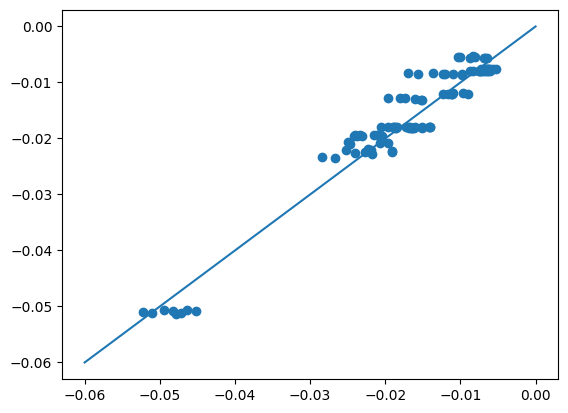

In [101]:
plt.scatter(wtheta_hmin_y, (wtheta_sfc_e1 - -0.041972034) * (rhs_e1 + -0.08939976))
plt.plot([-.06, 0], [-.06, 0])

In [90]:
# fit model (individiaul terms)
ef_individual_model.fit(X_individual, wtheta_hmin_y)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.680e+05
Head worker occupation: 11.1%
Progress: 946 / 15000 total iterations (6.307%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.188e-04  1.594e+01  y = -0.016779
3           2.122e-05  8.614e-01  y = wb_sfc * -6.3658
5           1.644e-05  1.276e-01  y = (-0.1774 * wtheta_sfc) - 0.0036883
7           1.276e-05  1.267e-01  y = (w_e * 0.45029) - (wb_sfc * dtheta_p)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.730e+05
Head worker occupation: 11.2%
Progress: 1905 / 15000 total iterations (12.700%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.188e-04  1.594e+01  y 

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                       -0.016806288   
	1        0.861407                                 wb_sfc * -6.365815   
	2        0.127727                (-5.415324 * wb_sfc) - 0.0036047294   
	3  >>>>  0.130192  (dtheta_p * -0.0011109042) + (wb_sfc * -5.3547...   
	
	       loss  complexity  
	0  0.000119           1  
	1  0.000021           3  
	2  0.000016           5  
	3  0.000013           7  
]

In [96]:
equations_ind = ef_individual_model.equations_
print(equations_ind.shape)
print("Final Equation (Individual Terms): ")
display(equations_ind.iloc[3, 3])
print(equations_ind.iloc[-1, 3])

(4, 6)
Final Equation (Individual Terms): 


'(dtheta_p * -0.0011109042) + (wb_sfc * -5.3547535)'

(dtheta_p * -0.0011109042) + (wb_sfc * -5.3547535)


### Final Equations (Individual Terms): 

* '(dtheta_p * -0.0011109042) + (wb_sfc * -5.3547535)'

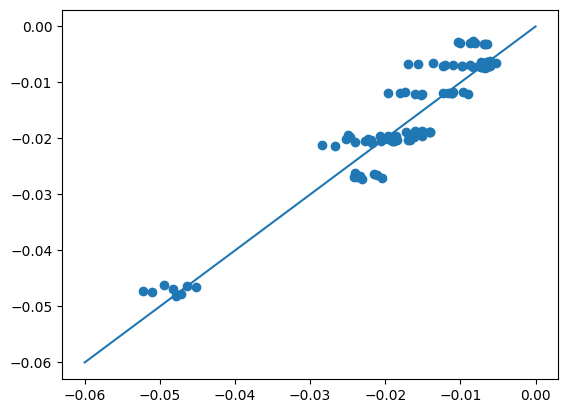

In [103]:
plt.scatter(wtheta_hmin_y, (dtheta_p_e1 * -0.0011109042) + (wb_sfc_e1 * -5.3547535))
plt.plot([-.06, 0], [-.06, 0])

In [107]:
ef_lvars_model.fit(X_lvars, wtheta_hmin_y)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.270e+05
Head worker occupation: 9.5%
Progress: 864 / 150000 total iterations (0.576%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.188e-04  1.594e+01  y = -0.016815
3           1.057e-04  5.831e-02  y = -0.013172 / del_eft
5           6.993e-05  2.067e-01  y = (detheta_p * -0.02466) * eft_sfc
7           4.036e-05  2.748e-01  y = (eft_sfc + 0.12833) * (we * detheta_p)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.470e+05
Head worker occupation: 7.9%
Progress: 1811 / 150000 total iterations (1.207%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.188e-04  1.594e+01  y

PySRRegressor.equations_ = [
	   pick     score                                     equation      loss  \
	0        0.000000                                 -0.016804792  0.000119   
	1        0.058313                       -0.013163701 / del_eft  0.000106   
	2        0.228586       -0.03085569 + (0.02409967 / detheta_p)  0.000067   
	3  >>>>  0.286416  (we + -0.009509747) * (eft_sfc * detheta_p)  0.000038   
	
	   complexity  
	0           1  
	1           3  
	2           5  
	3           7  
]

In [108]:
equations_lvars = ef_lvars_model.equations_
print(equations_lvars.shape)
print("Final Equation")
display(equations_lvars.iloc[3, 3])
print(equations_lvars.iloc[-1, 3])

(4, 6)
Final Equation


'(we + -0.009509747) * (eft_sfc * detheta_p)'

(we + -0.009509747) * (eft_sfc * detheta_p)


### Equation from Lvars simulation:

(we + -0.009509747) * (eft_sfc * detheta_p)

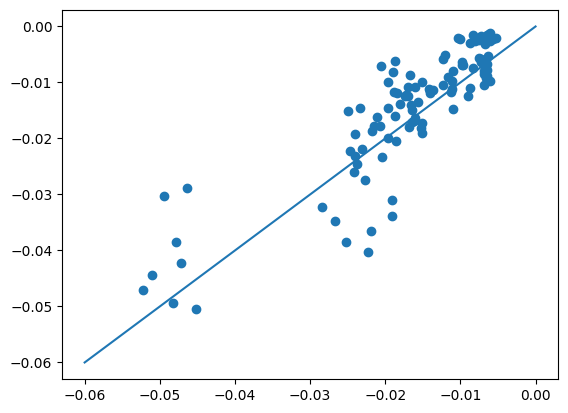

In [110]:
plt.scatter(wtheta_hmin_y, (w_e_e1 + -0.009509747) * (eft_sfc * dtheta_p_e1))
plt.plot([-0.06, 0], [-0.06, 0])